# 🔮 Churn Prediction: Machine Learning Pipeline

Este notebook implementa um pipeline robusto de Machine Learning para prever Churn de clientes.

### 🎯 Objetivos:
1. **Construir Pipelines** de processamento e modelagem.
2. **Testar Múltiplos Modelos**: Logistic Regression, Random Forest, XGBoost, LightGBM, CatBoost.
3. **Estratégias Avançadas**: Validação Cruzada Estratificada, SMOTE (dentro do fold), e Otimização de Hiperparâmetros.
4. **Probabilidade & Risco**: Gerar scores de 0 a 1 e classificar risco (Baixo, Médio, Alto) por **Percentis**.
5. **Interpretabilidade**: Explicar decisões do modelo com SHAP values.

In [17]:
# Bibliotecas essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# ML Core
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve, confusion_matrix, accuracy_score

# Imbalance Handling
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Interpretabilidade
import shap

# Configurações
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
SEED = 42
FOLDS = 5

## 📥 1. Carregamento e Preparação dos Dados

In [18]:
# Carregar dados processados
df_train = pd.read_csv('history_fe.csv')
df_inference = pd.read_csv('inference_fe.csv')

print(f"Treino Shape: {df_train.shape}")
print(f"Inferencia Shape: {df_inference.shape}")

# Separar Features e Target
# Garantir que CustomerID não vá para o modelo
X = df_train.drop(['customerID', 'Churn', 'CustomerFeedback'], axis=1, errors='ignore')

# Converter target para numérico se necessário
y = df_train['Churn'].apply(lambda x: 1 if x == 'Yes' or x == 1 else 0)

print(f"\nFeatures ({X.shape[1]}): {list(X.columns[:5])}...")
print(f"Target Balance:\n{y.value_counts(normalize=True)}")

Treino Shape: (5634, 45)
Inferencia Shape: (1409, 43)

Features (42): ['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService']...
Target Balance:
Churn
0    0.733049
1    0.266951
Name: proportion, dtype: float64


## 🛠️ 2. Construção do Pipeline de Validação

Uso de **SMOTE dentro do Cross-Validation** para evitar Data Leakage.
- **Passo 1**: Imputação (se houver NaNs restantes)
- **Passo 2**: Normalização (StandardScaler)
- **Passo 3**: SMOTE (apenas no treino do fold)
- **Passo 4**: Modelo

In [19]:
def get_pipeline(model, use_smote=True):
    """
    Cria um pipeline compatível com Imblearn
    """
    steps = [
        ('imputer', SimpleImputer(strategy='median')), # Prevenção contra NaNs residuais
        ('scaler', StandardScaler())   
    ]
    
    if use_smote:
        steps.append(('smote', SMOTE(random_state=SEED)))
        
    steps.append(('model', model))
    
    return ImbPipeline(steps)

# Model Zoo
models = {
    'LogisticRegression': LogisticRegression(random_state=SEED, max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=SEED, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=SEED, use_label_encoder=False, eval_metric='logloss', verbosity=0),
    'LightGBM': LGBMClassifier(random_state=SEED, verbosity=-1),
    'CatBoost': CatBoostClassifier(random_state=SEED, verbose=0, allow_writing_files=False)
}

## 🏎️ 3. Treinamento e Seleção de Modelos (Baseline)

In [20]:
results = []

print("Iniciando Validação Cruzada Estratificada (5 Folds)...\n")

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

for name, model in models.items():
    print(f"🚀 Treinando {name}...")
    pipe = get_pipeline(model, use_smote=True)
    
    # Métricas de avaliação
    cv_scores = cross_val_score(pipe, X, y, cv=skf, scoring='roc_auc', n_jobs=-1)
    
    print(f"   ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    results.append({
        'Model': name,
        'ROC_AUC_Mean': cv_scores.mean(),
        'ROC_AUC_Std': cv_scores.std()
    })

df_results = pd.DataFrame(results).sort_values(by='ROC_AUC_Mean', ascending=False)
print("\n🏆 Ranking de Modelos:")
print(df_results)

Iniciando Validação Cruzada Estratificada (5 Folds)...

🚀 Treinando LogisticRegression...
   ROC-AUC: 0.9314 (+/- 0.0047)
🚀 Treinando RandomForest...
   ROC-AUC: 0.9096 (+/- 0.0056)
🚀 Treinando XGBoost...
   ROC-AUC: 0.9309 (+/- 0.0042)
🚀 Treinando LightGBM...
   ROC-AUC: 0.9331 (+/- 0.0039)
🚀 Treinando CatBoost...
   ROC-AUC: 0.9361 (+/- 0.0024)

🏆 Ranking de Modelos:
                Model  ROC_AUC_Mean  ROC_AUC_Std
4            CatBoost      0.936110     0.002391
3            LightGBM      0.933130     0.003895
0  LogisticRegression      0.931379     0.004722
2             XGBoost      0.930855     0.004188
1        RandomForest      0.909564     0.005632


## 🔧 4. Otimização de Hiperparâmetros (Champion Model)
Selecionamos os top 2 modelos para tunagem fina.

In [21]:
# Exemplo com XGBoost (Geralmente performa muito bem)
# Definir espaço de busca
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 7],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

print("\n🔎 Iniciando Grid Search para XGBoost...")
xgb_pipe = get_pipeline(XGBClassifier(random_state=SEED, use_label_encoder=False, eval_metric='logloss'), use_smote=True)

grid_search = RandomizedSearchCV(
    xgb_pipe, 
    param_distributions=param_grid, 
    n_iter=20,
    scoring='roc_auc', 
    cv=3, 
    n_jobs=-1, 
    random_state=SEED, 
    verbose=1
)

grid_search.fit(X, y)

best_model = grid_search.best_estimator_
print(f"\n✅ Melhores Parâmetros: {grid_search.best_params_}")
print(f"✅ Melhor ROC-AUC: {grid_search.best_score_:.4f}")


🔎 Iniciando Grid Search para XGBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

✅ Melhores Parâmetros: {'model__subsample': 1.0, 'model__n_estimators': 300, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'model__colsample_bytree': 1.0}
✅ Melhor ROC-AUC: 0.9338


## 📊 5. Avaliação Final e Curvas
Análise detalhada do melhor modelo.


📄 Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       826
           1       0.74      0.75      0.75       301

    accuracy                           0.86      1127
   macro avg       0.82      0.83      0.83      1127
weighted avg       0.86      0.86      0.86      1127

ROC-AUC Score: 0.9328


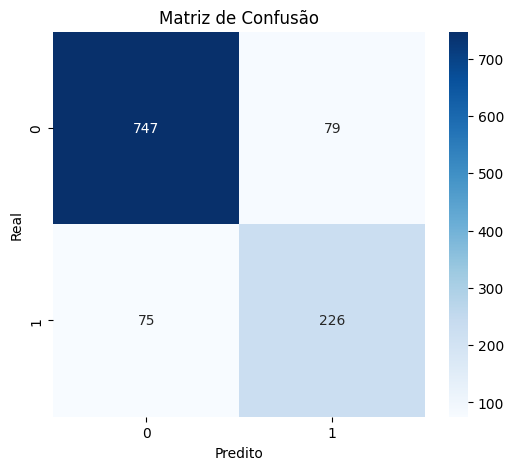

In [22]:
# Split de validação final para visualização
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

# Treinar melhor modelo no conjunto de treino
best_model.fit(X_train, y_train)

# Previsões
y_pred = best_model.predict(X_val)
y_prob = best_model.predict_proba(X_val)[:, 1]

print("\n📄 Relatório de Classificação:")
print(classification_report(y_val, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_val, y_prob):.4f}")

# Matriz de Confusão Visual
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.show()

## 🧠 6. Interpretabilidade com SHAP


🌟 SHAP Summary Plot (Impacto das Features):


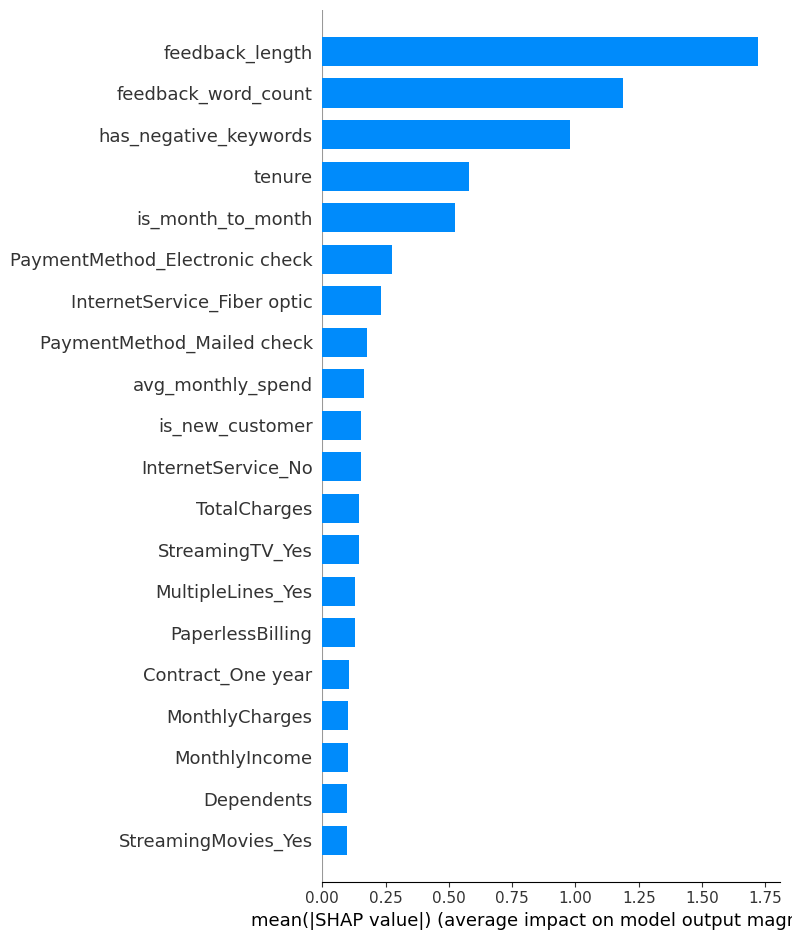

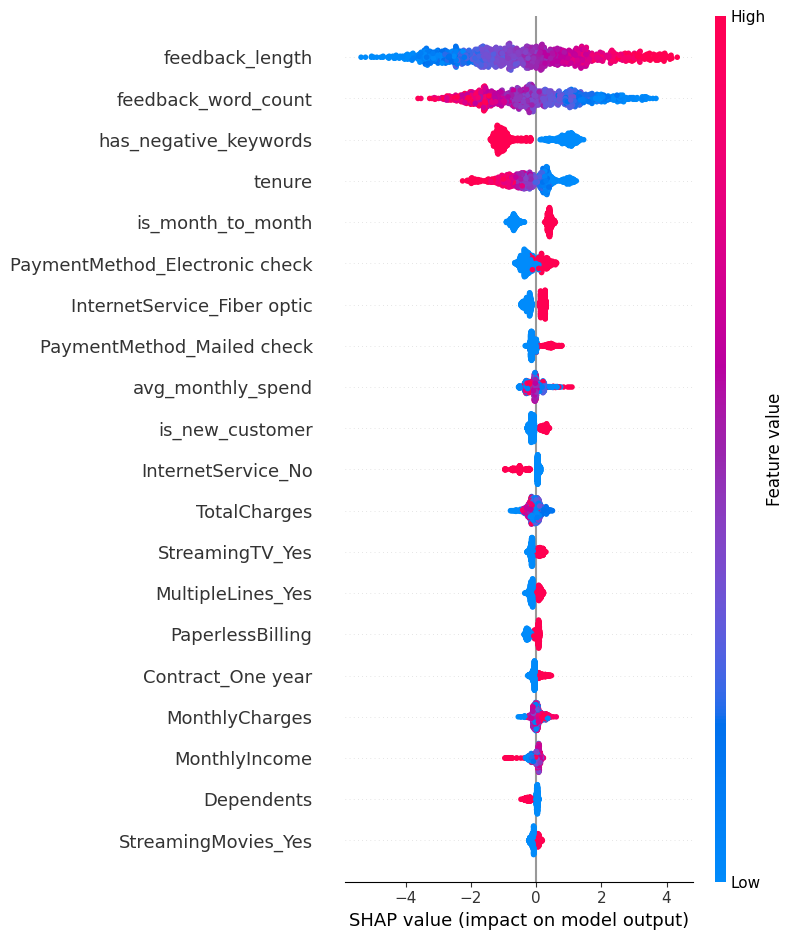

In [23]:
# SHAP para XGBoost/Tree models
# Precisamos acessar o modelo dentro do pipeline
final_estimator = best_model.named_steps['model']

# Pre-processar dados para SHAP (aplicar scaler/imputer se necessário)
# IMPORTANTE: Remover SMOTE do pipeline de preprocessamento para SHAP
# Selecionamos apenas transformadores (Imputer, Scaler)
transformers = [s for s in best_model.steps if s[0] not in ['smote', 'model']]
preprocessor = ImbPipeline(transformers)

# Ajustar preprocessor nos dados de treino (apenas transformações)
X_train_transformed = preprocessor.fit_transform(X_train, y_train)
X_val_transformed = preprocessor.transform(X_val)

# Calcular SHAP values
explainer = shap.TreeExplainer(final_estimator)
shap_values = explainer.shap_values(X_val_transformed)

print("\n🌟 SHAP Summary Plot (Impacto das Features):")
shap.summary_plot(shap_values, X_val, plot_type="bar")
shap.summary_plot(shap_values, X_val)

## 🚀 7. Inferência do Modelo Final, Probabilidades e Segmentação de Risco
Geração de previsões, probabilidades (0 a 1) e categorização de risco baseada em percentis.

In [25]:
# Preparar dados de inferência
# Garantir que features de NLP do treino existam na inferência
if 'feedback_word_count' not in df_inference.columns and 'CustomerFeedback' in df_inference.columns:
    print("🛠️ Recriando feature 'feedback_word_count'...")
    df_inference['feedback_word_count'] = df_inference['CustomerFeedback'].astype(str).str.split().str.len().fillna(0)

# Selecionar features (dropando as que não vão para o modelo)
X_inf = df_inference.drop(['customerID', 'Churn', 'CustomerFeedback'], axis=1, errors='ignore')

# Garantir consistência exata das colunas com o treino (Ordem e Presença)
missing_cols = set(X.columns) - set(X_inf.columns)
for c in missing_cols:
    X_inf[c] = 0  # Preencher features faltantes com 0 se necessário

X_inf = X_inf[X.columns] # Reordenar exatamente igual ao treino

ids = df_inference['customerID']

# Gerar Probabilidades (0 a 1)
probs = best_model.predict_proba(X_inf)[:, 1]

# Criar DataFrame de resultados
results_df = pd.DataFrame({
    'customerID': ids,
    'Churn_Probability': probs.round(4)
})

# Segmentação de Risco por Percentis
# Low Risk (0-50%), Medium Risk (50-75%), High Risk (75-100%)
results_df['Risk_Level'] = pd.qcut(results_df['Churn_Probability'], 
                                   q=[0, 0.5, 0.75, 1.0], 
                                   labels=['Low Risk', 'Medium Risk', 'High Risk'])

print("\n📊 Distribuição dos Níveis de Risco (Percentis):")
print(results_df['Risk_Level'].value_counts())

print("\n🔝 Top 10 Clientes com Maior Risco de Churn:")
print(results_df.sort_values(by='Churn_Probability', ascending=False).head(10))

# Salvar
results_df.to_csv('predictions_with_risk.csv', index=False)
print("\n💾 Arquivo salvo: predictions_with_risk.csv")


📊 Distribuição dos Níveis de Risco (Percentis):
Risk_Level
Low Risk       705
Medium Risk    352
High Risk      352
Name: count, dtype: int64

🔝 Top 10 Clientes com Maior Risco de Churn:
      customerID  Churn_Probability Risk_Level
1121  6513-EECDB             0.9973  High Risk
1112  5376-DEQCP             0.9946  High Risk
1393  4102-OQUPX             0.9941  High Risk
1152  4910-GMJOT             0.9921  High Risk
971   9787-XVQIU             0.9913  High Risk
1245  9248-OJYKK             0.9910  High Risk
1377  0107-YHINA             0.9901  High Risk
840   6100-QQHEB             0.9899  High Risk
651   5276-KQWHG             0.9894  High Risk
692   4550-EVXNY             0.9885  High Risk

💾 Arquivo salvo: predictions_with_risk.csv
